In [1]:
# libraries
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
# display for notebooks
%matplotlib inline

In [3]:
# Versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)

numpy version: 1.18.1
pandas version: 1.0.1
Seaborn version: 0.10.0


In [4]:
# loading the dataset
url = "https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv"

In [5]:
# creating a dataframe
covid_pt = pd.read_csv(url, index_col = "data", parse_dates = True, dayfirst = True)
#covid_pt = pd.read_csv(url, index_col = "data", sep = ";", parse_dates = True, dayfirst = True)
#covid_pt = pd.read_csv(url, parse_dates = True, dayfirst = True)

In [6]:
# checking the dataframe
covid_pt.head()
covid_pt.tail()

,data_dados,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,...,confirmados_f,confirmados_m,obitos_arsnorte,obitos_arscentro,obitos_arslvt,obitos_arsalentejo,obitos_arsalgarve,obitos_acores,obitos_madeira,obitos_estrangeiro
data,,,,,,,,,,,,,,,,,,,,,
2020-03-21,21/03/2020 00:00,1280,644,137,448,3,31,3,5,9.0,...,649.0,631.0,4,4,3,0,1,0,0,0
2020-03-22,22/03/2020 00:00,1600,825,180,534,5,35,4,7,10.0,...,821.0,779.0,5,4,4,0,1,0,0,0
2020-03-23,23/03/2020 00:00,2060,1007,238,737,5,42,11,9,11.0,...,1080.0,980.0,9,5,8,0,1,0,0,0
2020-03-24,24/03/2020 00:00,2362,1130,293,852,6,46,12,12,11.0,...,1234.0,1128.0,14,6,12,0,1,0,0,0
2020-03-25,25/03/2020 00:00,2995,1517,365,992,12,62,17,16,14.0,...,1586.0,1409.0,20,10,12,0,1,0,0,0


In [47]:
# checking the columns of the df
covid_pt.columns

Index(['data_dados', 'confirmados', 'confirmados_arsnorte',
       'confirmados_arscentro', 'confirmados_arslvt',
       'confirmados_arsalentejo', 'confirmados_arsalgarve',
       'confirmados_acores', 'confirmados_madeira', 'confirmados_estrangeiro',
       'confirmados_novos', 'recuperados', 'obitos', 'internados',
       'internados_uci', 'lab', 'suspeitos', 'vigilancia', 'n_confirmados',
       'cadeias_transmissao', 'transmissao_importada', 'confirmados_0_9_f',
       'confirmados_0_9_m', 'confirmados_10_19_f', 'confirmados_10_19_m',
       'confirmados_20_29_f', 'confirmados_20_29_m', 'confirmados_30_39_f',
       'confirmados_30_39_m', 'confirmados_40_49_f', 'confirmados_40_49_m',
       'confirmados_50_59_f', 'confirmados_50_59_m', 'confirmados_60_69_f',
       'confirmados_60_69_m', 'confirmados_70_79_f', 'confirmados_70_79_m',
       'confirmados_80_plus_f', 'confirmados_80_plus_m', 'sintomas_tosse',
       'sintomas_febre', 'sintomas_dificuldade_respiratoria',
       'sinto

# 📔 Dicionário dos dados

Uma explicação do conteúdo em `data.csv`. 

📝 _ARS_: Administração Regional de Saúde 

| Nome da coluna        | Significado           | Possíveis valores  |
| ------------- |:-------------:| -----:|
| `data` | Data da publicação dos dados. | DD-MM-YYYY |
| `data_dados` | Data e hora da recolha dos dados apresentados (quando omitida nos relatórios, assume-se como sendo a data da publicação dos dados). **Geralmente, os dados são reportados até às 24h do dia anterior à `data` (equivalentes às 00h do dia de `data`, sendo este último o formato utilizado).** | DD-MM-YYYY HH:MM|
| `confirmados` | Casos confirmados      | Inteiro >= 0 |
| `confirmados_arsnorte` | Casos confirmados na ARS Norte      | Inteiro >= 0 |
| `confirmados_arscentro` | Casos confirmados na ARS Centro      | Inteiro >= 0 |
| `confirmados_arslvt` | Casos confirmados na ARS Lisboa e Vale do Tejo      | Inteiro >= 0 |
| `confirmados_alentejo` | Casos confirmados na ARS Alentejo     | Inteiro >= 0 |
| `confirmados_arsalgarve` | Casos confirmados na ARS Algarve    | Inteiro >= 0 |
| `confirmados_acores` | Casos confirmados na Região Autónoma dos Açores | Inteiro >= 0 |
| `confirmados_madeira` | Casos confirmados na Região Autónoma da Madeira  |  Inteiro >= 0 |
| `confirmados_estrangeiro` | Casos confirmados no estrangeiro | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_novos` | Número de novos casos confirmados comparativamente ao dia anterior. É uma coluna calculada a partir da diferença nos casos `confirmados` entre dias consecutivos. | Inteiro >= 0 |
| `recuperados` | Total de casos recuperados | Inteiro >= 0 |
| `obitos` | Total de óbitos | Inteiro >= 0 |
| `internados` | Número de pacientes COVID-19 internados | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `internados_uci` | Número de pacientes COVID-19 internados em Unidades de Cuidados Intensivos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `lab` | Número de casos suspeitos a aguardar resultados laboratoriais | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `suspeitos` | Total de casos suspeitos (tendo a [definição sido actualizada](https://www.dgs.pt/directrizes-da-dgs/orientacoes-e-circulares-informativas/orientacao-n-002a2020-de-25012020-atualizada-a-250220201.aspx) a 29/02/2020) desde 01/01/2020  | Inteiro >= 0 |
| `vigilancia` | Número de casos sob vigilância pelas autoridades de saúde | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `n_confirmados` | Número de casos cuja suspeita de infecção não se confirmou | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `cadeias_transmissao` | Número de cadeias de transmissão do SARS-CoV-2 activas | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `transmissao_importada` | Número de casos confirmados com transmissão por via de infectados de outros países | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_0_9_f` | Número de casos confirmados do sexo feminino na faixa etária 0-9 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_0_9_m` | Número de casos confirmados do sexo masculino na faixa etária 0-9 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_10_19_f` | Número de casos confirmados do sexo feminino na faixa etária 10-19 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_10_19_m` | Número de casos confirmados do sexo masculino na faixa etária 10-19 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_20_29_f` | Número de casos confirmados do sexo feminino na faixa etária 20-29 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_20_29_m` | Número de casos confirmados do sexo masculino na faixa etária 20-29 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_30_39_f` | Número de casos confirmados do sexo feminino na faixa etária 30-39 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_30_39_m` | Número de casos confirmados do sexo masculino na faixa etária 30-39 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_40_49_f` | Número de casos confirmados do sexo feminino na faixa etária 40-49 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_40_49_m` | Número de casos confirmados do sexo masculino na faixa etária 40-49 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_50_59_f` | Número de casos confirmados do sexo feminino na faixa etária 50-59 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_50_59_m` | Número de casos confirmados do sexo masculino na faixa etária 50-59 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_60_69_f` | Número de casos confirmados do sexo feminino na faixa etária 60-69 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_60_69_m` | Número de casos confirmados do sexo masculino na faixa etária 60-69 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_70_79_f` | Número de casos confirmados do sexo feminino na faixa etária 70-79 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_70_79_m` | Número de casos confirmados do sexo masculino na faixa etária 70-79 anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_80_plus_f` | Número de casos confirmados do sexo feminino na faixa etária 80+ anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_80_plus_m` | Número de casos confirmados do sexo masculino na faixa etária 80+ anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_80_plus_m` | Número de casos confirmados do sexo masculino na faixa etária 80+ anos | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `sintomas_tosse` | Percentagem de casos infetados que reportaram o sintoma de tosse | fracção entre [0, 1] ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `sintomas_febre` | Percentagem de casos infetados que reportaram o sintoma de febre | fracção entre [0, 1] ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `sintomas_dificuldade_respiratoria` | Percentagem de casos infetados que reportaram o sintoma de dificuldade respiratória | fracção entre [0, 1] ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `sintomas_cefaleia` | Percentagem de casos infetados que reportaram o sintoma de cefaleia ou dores de cabeça | fracção entre [0, 1] ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `sintomas_dores_musculares` | Percentagem de casos infetados que reportaram o sintoma de dores musculares | fracção entre [0, 1] ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `sintomas_fraqueza_generalizada` | Percentagem de casos infetados que reportaram o sintoma de fraqueza generalizada | fracção entre [0, 1] ou _vazio_ para os dias em que a DGS não reportava este indicador |
| `confirmados_f` | Número total de confirmados do sexo feminino | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava directamente este indicador |
| `confirmados_m` | Número total de confirmados do sexo masculino | Inteiro >= 0 ou _vazio_ para os dias em que a DGS não reportava directamente este indicador |
| `obitos_arsnorte` | Total de óbitos na ARS Norte      | Inteiro >= 0 |
| `obitos_arscentro` | Total de óbitos na ARS Centro      | Inteiro >= 0 |
| `obitos_arslvt` | Total de óbitos na ARS Lisboa e Vale do Tejo      | Inteiro >= 0 |
| `obitos_alentejo` | Total de óbitos na ARS Alentejo     | Inteiro >= 0 |
| `obitos_arsalgarve` | Total de óbitos na ARS Algarve    | Inteiro >= 0 |
| `obitos_acores` | Total de óbitos na Região Autónoma dos Açores | Inteiro >= 0 |
| `obitos_madeira` | Total de óbitos na Região Autónoma da Madeira  |  Inteiro >= 0 |
| `obitos_estrangeiro` | Total de óbitos no estrangeiro | Inteiro >= 0 |

> Definições exactas de alguns destes termos constam do glossário do [Plano Nacional de Preparação e Resposta à Doença por novo coronavírus (COVID-19)](https://covid19.min-saude.pt/wp-content/uploads/2020/03/Plano-de-Conting%C3%AAncia-Novo-Coronavirus_Covid-19.pdf) (página 65 em diante).

Uma outra métrica com potencial interesse científico, o número de casos com base na data de início de sintomas, é também reportada pela DGS. No entanto, é apenas disponibilizado um gráfico de eixos esparsos, o que pode introduzir erros de aproximação na transcrição e comprometer a factualidade dos dados. Por essa razão, esta informação é propositadamente excluída. 

In [48]:
# checking the datatypes
print(covid_pt.index)
covid_pt.dtypes

DatetimeIndex(['2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25'],
              dtype='datetime64[ns]', name='data', freq=None)


data_dados                            object
confirmados                            int64
confirmados_arsnorte                   int64
confirmados_arscentro                  int64
confirmados_arslvt                     int64
confirmados_arsalentejo                int64
confirmados_arsalgarve                 int64
confirmados_acores                     int64
confirmados_madeira                    int64
confirmados_estrangeiro              float64
confirmados_novos                      int64
recuperados                            int64
obitos                                 int64
internados                           float64
internados_uci                       float64
lab                                  float64
suspeitos                              int64
vigilancia                           float64
n_confirmados                        float64
cadeias_transmissao                  float64
transmissao_importada                float64
confirmados_0_9_f                    float64
confirmado

In [8]:
# checking the size of the df
covid_pt.shape

(29, 55)

In [9]:
#gathering descriptive statistics on the df
round(covid_pt.describe(), 2)

,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,confirmados_novos,...,confirmados_f,confirmados_m,obitos_arsnorte,obitos_arscentro,obitos_arslvt,obitos_arsalentejo,obitos_arsalgarve,obitos_acores,obitos_madeira,obitos_estrangeiro
count,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,14.00,29.00,...,7.00,7.00,29.00,29.00,29.00,29.0,29.00,29.0,29.0,29.0
mean,494.86,243.34,55.24,175.24,1.28,12.21,2.03,1.79,7.43,103.28,...,895.14,833.71,1.83,1.10,1.55,0.0,0.21,0.0,0.0,0.0
std,810.29,402.55,97.52,279.64,2.70,17.00,4.18,4.07,3.86,159.21,...,427.97,360.03,4.71,2.41,3.37,0.0,0.41,0.0,0.0,0.0
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,390.00,395.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0
25%,6.00,3.00,1.00,2.00,0.00,0.00,0.00,0.00,5.00,2.00,...,577.50,572.50,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0
50%,59.00,36.00,3.00,17.00,0.00,3.00,0.00,0.00,9.00,18.00,...,821.00,779.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0
75%,642.00,289.00,74.00,243.00,2.00,21.00,3.00,1.00,9.75,143.00,...,1157.00,1054.00,0.00,0.00,1.00,0.0,0.00,0.0,0.0,0.0
max,2995.00,1517.00,365.00,992.00,12.00,62.00,17.00,16.00,14.00,633.00,...,1586.00,1409.00,20.00,10.00,12.00,0.0,1.00,0.0,0.0,0.0


In [10]:
# checking the columns that the df has
covid_pt.columns

Index(['data_dados', 'confirmados', 'confirmados_arsnorte',
       'confirmados_arscentro', 'confirmados_arslvt',
       'confirmados_arsalentejo', 'confirmados_arsalgarve',
       'confirmados_acores', 'confirmados_madeira', 'confirmados_estrangeiro',
       'confirmados_novos', 'recuperados', 'obitos', 'internados',
       'internados_uci', 'lab', 'suspeitos', 'vigilancia', 'n_confirmados',
       'cadeias_transmissao', 'transmissao_importada', 'confirmados_0_9_f',
       'confirmados_0_9_m', 'confirmados_10_19_f', 'confirmados_10_19_m',
       'confirmados_20_29_f', 'confirmados_20_29_m', 'confirmados_30_39_f',
       'confirmados_30_39_m', 'confirmados_40_49_f', 'confirmados_40_49_m',
       'confirmados_50_59_f', 'confirmados_50_59_m', 'confirmados_60_69_f',
       'confirmados_60_69_m', 'confirmados_70_79_f', 'confirmados_70_79_m',
       'confirmados_80_plus_f', 'confirmados_80_plus_m', 'sintomas_tosse',
       'sintomas_febre', 'sintomas_dificuldade_respiratoria',
       'sinto

In [11]:
# dropping all columns except the ones below, since I'm not interested in this info for the 
# purpose of this study
covid19_pt = covid_pt.filter(['confirmados', 'confirmados_novos', 'recuperados', 'obitos', 
                              'internados', 'internados_uci', 'lab', 'suspeitos', 
                              'vigilancia', 'n_confirmados', 'cadeias_transmissao', 
                              'transmissao_importada'])

In [12]:
# checking the tail
covid19_pt.tail()

,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada
data,,,,,,,,,,,,
2020-03-21,1280,260,5,12,156.0,35.0,1059.0,9854,13155.0,7515.0,NaN,104.0
2020-03-22,1600,320,5,14,169.0,41.0,1152.0,11779,12562.0,9027.0,NaN,114.0
2020-03-23,2060,460,14,23,201.0,47.0,1402.0,13674,11842.0,10212.0,NaN,142.0
2020-03-24,2362,302,22,33,203.0,48.0,1783.0,15474,11842.0,11329.0,NaN,142.0
2020-03-25,2995,633,22,43,276.0,61.0,1591.0,21155,13624.0,16569.0,NaN,155.0


In [13]:
#checking the new shape 
covid19_pt.shape

(29, 12)

In [14]:
# rechecking the types
covid19_pt.dtypes

confirmados                int64
confirmados_novos          int64
recuperados                int64
obitos                     int64
internados               float64
internados_uci           float64
lab                      float64
suspeitos                  int64
vigilancia               float64
n_confirmados            float64
cadeias_transmissao      float64
transmissao_importada    float64
dtype: object

In [15]:
# different ways to check the % of nulls in a df/series
print("Abs by Column:\n", covid19_pt.isna().sum())
print("\n% by Column:\n", covid19_pt.isna().mean().round(4) * 100)

Abs by Column:
 confirmados               0
confirmados_novos         0
recuperados               0
obitos                    0
internados                8
internados_uci           17
lab                       9
suspeitos                 0
vigilancia                7
n_confirmados            18
cadeias_transmissao      14
transmissao_importada     6
dtype: int64

% by Column:
 confirmados               0.00
confirmados_novos         0.00
recuperados               0.00
obitos                    0.00
internados               27.59
internados_uci           58.62
lab                      31.03
suspeitos                 0.00
vigilancia               24.14
n_confirmados            62.07
cadeias_transmissao      48.28
transmissao_importada    20.69
dtype: float64


In [16]:
# Shan't change to int due to the NaN's!


In [17]:
# rechecking the descriptive stats
round(covid19_pt.describe(), 2)

,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada
count,29.00,29.00,29.00,29.00,21.00,12.00,20.00,29.00,22.00,11.00,15.00,23.00
mean,494.86,103.28,3.03,4.69,109.10,29.33,522.55,3664.31,5643.64,6962.18,12.20,51.52
std,810.29,159.21,6.01,10.72,74.37,16.75,569.31,5600.37,4722.97,4520.41,7.69,50.69
min,0.00,0.00,0.00,0.00,9.00,9.00,30.00,25.00,81.00,1746.00,4.00,2.00
25%,6.00,2.00,0.00,0.00,40.00,17.75,83.00,117.00,538.75,3666.50,6.00,6.50
50%,59.00,18.00,0.00,0.00,107.00,23.00,302.00,471.00,4967.00,5862.00,11.00,39.00
75%,642.00,143.00,3.00,1.00,156.00,42.50,902.25,5067.00,8778.75,9619.50,18.50,83.00
max,2995.00,633.00,22.00,43.00,276.00,61.00,1783.00,21155.00,13624.00,16569.00,24.00,155.00


In [18]:
# checking for simple correlations
# correlation matrix to prepare the heatmap
corr_matrix = covid19_pt.corr()

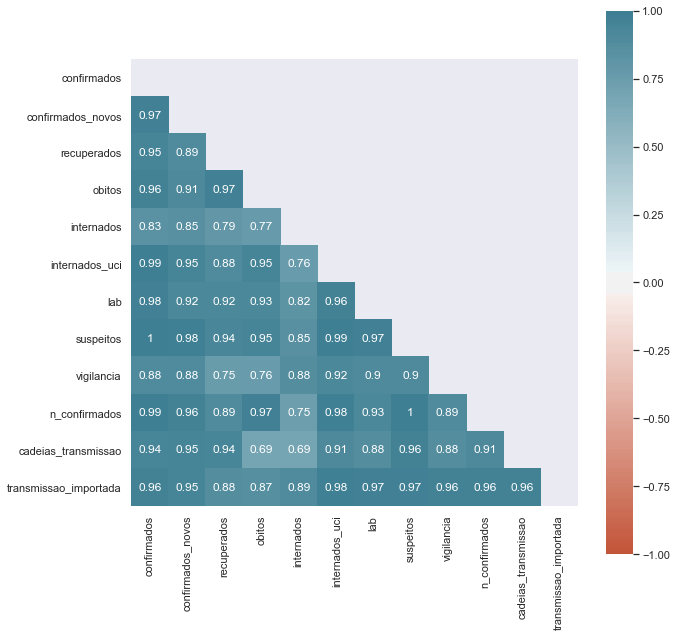

In [19]:
# creating the heatmap
# setting the style
sns.set("notebook")

# Generating a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype = np.bool))

# plotting
fig, ax = plt.subplots(figsize = (10, 10)) 
with sns.axes_style("white"):
    p2 = sns.heatmap(corr_matrix, mask = mask, square = True, fmt = "0.2g", vmin = -1, 
                     vmax = 1, center = 0, cmap = sns.diverging_palette(20, 220, n = 200), 
                     annot = True)

In [20]:
# documentation says: n_confirmados == "Número de casos cuja suspeita de infecção não se 
# confirmou".
# I'm keeping the NaN's as is — for now.

In [21]:
# checking head
covid19_pt.tail()

,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada
data,,,,,,,,,,,,
2020-03-21,1280,260,5,12,156.0,35.0,1059.0,9854,13155.0,7515.0,NaN,104.0
2020-03-22,1600,320,5,14,169.0,41.0,1152.0,11779,12562.0,9027.0,NaN,114.0
2020-03-23,2060,460,14,23,201.0,47.0,1402.0,13674,11842.0,10212.0,NaN,142.0
2020-03-24,2362,302,22,33,203.0,48.0,1783.0,15474,11842.0,11329.0,NaN,142.0
2020-03-25,2995,633,22,43,276.0,61.0,1591.0,21155,13624.0,16569.0,NaN,155.0


In [22]:
# adding weekday
covid19_pt["dia"] = covid19_pt.index.day_name()

In [23]:
# calculating  'R0'(número básico de reprodução)
covid19_pt["factor_propagacao"] = 1 + round(covid19_pt["confirmados"].pct_change(), 2)

In [24]:
# calculating number of days it will take to double the amount of infected at that rate.
covid19_pt["dias_duplicar"] = round(np.log(2) / np.log(covid19_pt["factor_propagacao"]), 0)

In [25]:
# creating a reorder of the columns
"""reorded = ['data', 'dia', 'confirmados', 'factor_propagacao', 'dias_duplicar',
           'internados', 'internados_uci', 'lab', 'suspeitos', 'vigilancia', 
           'cadeias_transmissao', 'transmissao_importada']"""

"reorded = ['data', 'dia', 'confirmados', 'factor_propagacao', 'dias_duplicar',\n           'internados', 'internados_uci', 'lab', 'suspeitos', 'vigilancia', \n           'cadeias_transmissao', 'transmissao_importada']"

In [26]:
"""# reordering the data
covid19_pt = covid19_pt[reorded]"""

'# reordering the data\ncovid19_pt = covid19_pt[reorded]'

In [46]:
# checking
covid19_pt.tail(6)

,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada,dia,factor_propagacao,dias_duplicar,conf_p_labs,obitos_p_conf,interns_p_conf,uci_p_internados
data,,,,,,,,,,,,,,,,,,,
2020-03-20,1020,235,5,6,126.0,26.0,850.0,7732,9008.0,5862.0,24.0,95.0,Friday,1.30,3.0,0.28,0.0059,0.12,0.21
2020-03-21,1280,260,5,12,156.0,35.0,1059.0,9854,13155.0,7515.0,NaN,104.0,Saturday,1.25,3.0,0.25,0.0094,0.12,0.22
2020-03-22,1600,320,5,14,169.0,41.0,1152.0,11779,12562.0,9027.0,NaN,114.0,Sunday,1.25,3.0,0.28,0.0088,0.11,0.24
2020-03-23,2060,460,14,23,201.0,47.0,1402.0,13674,11842.0,10212.0,NaN,142.0,Monday,1.29,3.0,0.33,0.0112,0.10,0.23
2020-03-24,2362,302,22,33,203.0,48.0,1783.0,15474,11842.0,11329.0,NaN,142.0,Tuesday,1.15,5.0,0.17,0.0140,0.09,0.24
2020-03-25,2995,633,22,43,276.0,61.0,1591.0,21155,13624.0,16569.0,NaN,155.0,Wednesday,1.27,3.0,0.40,0.0144,0.09,0.22


In [49]:
# according to https://twitter.com/jcaetanodias (March 25, 2020) this is how you get the 
# number of tests (see: https://t.co/prnbCVRWet or
# https://twitter.com/jcaetanodias/status/1242791783773409285?ref_src=twsrc%5Etfw ):
covid19_pt["testes_p_dia"] = 
covid19_pt["accum_testes"] = covid19_pt["confirmados"] + covid19_pt["n_confirmados"]

In [50]:
covid19_pt

,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada,dia,factor_propagacao,dias_duplicar,conf_p_labs,obitos_p_conf,interns_p_conf,uci_p_internados,testes
data,,,,,,,,,,,,,,,,,,,,
2020-02-26,0,0,0,0,NaN,NaN,NaN,25,NaN,NaN,NaN,NaN,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-27,0,0,0,0,NaN,NaN,NaN,51,NaN,NaN,NaN,NaN,Thursday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,0,0,0,0,NaN,NaN,NaN,59,NaN,NaN,NaN,NaN,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,0,0,0,0,NaN,NaN,NaN,70,NaN,NaN,NaN,NaN,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,0,0,0,0,NaN,NaN,NaN,85,NaN,NaN,NaN,NaN,Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,2,2,0,0,NaN,NaN,NaN,85,NaN,NaN,NaN,NaN,Monday,inf,0.0,NaN,0.0000,NaN,NaN,NaN
2020-03-03,4,2,0,0,NaN,NaN,NaN,101,NaN,NaN,NaN,2.0,Tuesday,2.00,1.0,NaN,0.0000,NaN,NaN,NaN
2020-03-04,6,2,0,0,NaN,NaN,NaN,117,81.0,NaN,NaN,4.0,Wednesday,1.50,2.0,NaN,0.0000,NaN,NaN,NaN
2020-03-05,9,3,0,0,9.0,NaN,NaN,147,213.0,NaN,NaN,5.0,Thursday,1.50,2.0,NaN,0.0000,1.00,NaN,NaN


In [28]:
# creating function to check and insert relations into the DF
def relations(dividend, divisor):
    """"""
    relation = round(dividend.div(divisor), 2)
    
    return relation

In [29]:
"""covid19_pt["test"] = covid19_pt.apply(relations(covid19_pt.["confirmados_novos"], 
                                                covid19_pt["lab"]))

covid19_pt["test"]"""

'covid19_pt["test"] = covid19_pt.apply(relations(covid19_pt.["confirmados_novos"], \n                                                covid19_pt["lab"]))\n\ncovid19_pt["test"]'

In [30]:
# calculating values for confirmados_novos / testes (lab?) —> (how many where confirmed given
# the tests)
confirmados_por_testes = round(covid19_pt.loc[:, "confirmados_novos"].div(covid19_pt["lab"]),
                               2)

In [31]:
# inserting the values into the DataFrame
covid19_pt.insert(loc = len(covid19_pt.columns), column = "conf_p_labs", 
                  value = confirmados_por_testes)

In [32]:
# checking
covid19_pt[["dia", "lab", "confirmados_novos", "conf_p_labs", "n_confirmados"]]

,dia,lab,confirmados_novos,conf_p_labs,n_confirmados
data,,,,,
2020-02-26,Wednesday,NaN,0,NaN,NaN
2020-02-27,Thursday,NaN,0,NaN,NaN
2020-02-28,Friday,NaN,0,NaN,NaN
2020-02-29,Saturday,NaN,0,NaN,NaN
2020-03-01,Sunday,NaN,0,NaN,NaN
2020-03-02,Monday,NaN,2,NaN,NaN
2020-03-03,Tuesday,NaN,2,NaN,NaN
2020-03-04,Wednesday,NaN,2,NaN,NaN
2020-03-05,Thursday,NaN,3,NaN,NaN


In [33]:
# Quantos testes se estão a fazer por dia? 
# De dia 03/06 a dia 03/15 há registo de 1078 labs (30 + 47 + 56 + 67 + 83 + 83 + 133 + 172
# + 126 + 281), mas 1746 ("Número de casos cuja suspeita de infecção não se confirmou")

In [34]:
# calculating values for obitos / confirmados 
obitos_p_confirmados = round(covid19_pt.loc[:, "obitos"].div(covid19_pt["confirmados"]), 4)

In [35]:
# inserting the values into the DataFrame
covid19_pt.insert(loc = len(covid19_pt.columns), column = "obitos_p_conf", 
                  value = obitos_p_confirmados)

In [36]:
# checking
covid19_pt[["dia", "confirmados", "obitos", "obitos_p_conf"]]

,dia,confirmados,obitos,obitos_p_conf
data,,,,
2020-02-26,Wednesday,0,0,NaN
2020-02-27,Thursday,0,0,NaN
2020-02-28,Friday,0,0,NaN
2020-02-29,Saturday,0,0,NaN
2020-03-01,Sunday,0,0,NaN
2020-03-02,Monday,2,0,0.0000
2020-03-03,Tuesday,4,0,0.0000
2020-03-04,Wednesday,6,0,0.0000
2020-03-05,Thursday,9,0,0.0000


In [37]:
# calculating values for internados / confirmados 
internados_p_confirmados = round(covid19_pt.loc[:, "internados"].div(covid19_pt["confirmados"]), 2)

In [38]:
# inserting the values into the DataFrame
covid19_pt.insert(loc = len(covid19_pt.columns), column = "interns_p_conf", 
                  value = internados_p_confirmados)

In [39]:
# checking
covid19_pt[["dia", "confirmados", "internados", "interns_p_conf", "obitos", "recuperados"]]

,dia,confirmados,internados,interns_p_conf,obitos,recuperados
data,,,,,,
2020-02-26,Wednesday,0,NaN,NaN,0,0
2020-02-27,Thursday,0,NaN,NaN,0,0
2020-02-28,Friday,0,NaN,NaN,0,0
2020-02-29,Saturday,0,NaN,NaN,0,0
2020-03-01,Sunday,0,NaN,NaN,0,0
2020-03-02,Monday,2,NaN,NaN,0,0
2020-03-03,Tuesday,4,NaN,NaN,0,0
2020-03-04,Wednesday,6,NaN,NaN,0,0
2020-03-05,Thursday,9,9.0,1.00,0,0


In [40]:
# Note-se a descida abrupta de 96% para 67% de dia 13 (alterações na política de 
# internamento?); Foi também o dia em que enceraram as escolas (¯\_(ツ)_/¯)
# 1ª recuperação no dia seguinte.

# E a descida de 46% para 14% (206 para 89 em valores absolutos) de dia 17 para 18
# Dia do primeiro óbito?

In [41]:
# calculating values for internados_uci / internados 
uci_p_interns = round(covid19_pt.loc[:, "internados_uci"].div(covid19_pt["internados"]), 2)

In [42]:
# inserting the values into the DataFrame
covid19_pt.insert(loc = len(covid19_pt.columns), column = "uci_p_internados", 
                  value = uci_p_interns)

In [43]:
# checking
covid19_pt[["dia", "internados", "internados_uci", "uci_p_internados"]]

,dia,internados,internados_uci,uci_p_internados
data,,,,
2020-02-26,Wednesday,NaN,NaN,NaN
2020-02-27,Thursday,NaN,NaN,NaN
2020-02-28,Friday,NaN,NaN,NaN
2020-02-29,Saturday,NaN,NaN,NaN
2020-03-01,Sunday,NaN,NaN,NaN
2020-03-02,Monday,NaN,NaN,NaN
2020-03-03,Tuesday,NaN,NaN,NaN
2020-03-04,Wednesday,NaN,NaN,NaN
2020-03-05,Thursday,9.0,NaN,NaN


In [44]:
covid19_pt.tail()

,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada,dia,factor_propagacao,dias_duplicar,conf_p_labs,obitos_p_conf,interns_p_conf,uci_p_internados
data,,,,,,,,,,,,,,,,,,,
2020-03-21,1280,260,5,12,156.0,35.0,1059.0,9854,13155.0,7515.0,NaN,104.0,Saturday,1.25,3.0,0.25,0.0094,0.12,0.22
2020-03-22,1600,320,5,14,169.0,41.0,1152.0,11779,12562.0,9027.0,NaN,114.0,Sunday,1.25,3.0,0.28,0.0088,0.11,0.24
2020-03-23,2060,460,14,23,201.0,47.0,1402.0,13674,11842.0,10212.0,NaN,142.0,Monday,1.29,3.0,0.33,0.0112,0.10,0.23
2020-03-24,2362,302,22,33,203.0,48.0,1783.0,15474,11842.0,11329.0,NaN,142.0,Tuesday,1.15,5.0,0.17,0.0140,0.09,0.24
2020-03-25,2995,633,22,43,276.0,61.0,1591.0,21155,13624.0,16569.0,NaN,155.0,Wednesday,1.27,3.0,0.40,0.0144,0.09,0.22


In [45]:
# https://www.dn.pt/pais/testes-ao-covid-19-portugal-nega-racionamento-e-nos-outros-paises-11975234.html
# https://www.dgs.pt/directrizes-da-dgs/orientacoes-e-circulares-informativas/orientacao-n-0062020-de-26022020-pdf.aspx
# https://towardsdatascience.com/why-the-coronavirus-mortality-rate-is-misleading-cc63f571b6a6
# https://www.dgs.pt/directrizes-da-dgs/orientacoes-e-circulares-informativas/orientacao-n-0062020-de-26022020-pdf.aspx
# https://medium.com/@charitnar/exploring-the-coronavirus-mortality-rate-82a86fb2c31
# https://covid19.min-saude.pt/wp-content/uploads/2020/03/i026056.pdf
# https://covid19.min-saude.pt/wp-content/uploads/2020/03/i026066.pdf
# https://www.dgs.pt/directrizes-da-dgs/orientacoes-e-circulares-informativas/orientacao-n-002a2020-de-25012020-atualizada-a-250220201.aspx
# 